In [2]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

from collections.abc import Callable
from typing import List

# Need a way to frame regression
# Express it as a linear regression (polynomial regression)
# Eigenfeatures


In [3]:
# List the different specifications of the dataset
df_raw = pd.read_csv('data/CarPrice_Assignment.csv')
print(f"Num samples: {df_raw.shape[0]}")
print(f"Num raw features: {df_raw.shape[1]}")
print()

for col in df_raw.columns:
    if df_raw[col].dtype == 'float64' or df_raw[col].dtype == 'int64':
        print(f"{col}: {df_raw[col].dtype}")

Num samples: 205
Num raw features: 26

car_ID: int64
symboling: int64
wheelbase: float64
carlength: float64
carwidth: float64
carheight: float64
curbweight: int64
enginesize: int64
boreratio: float64
stroke: float64
compressionratio: float64
horsepower: int64
peakrpm: int64
citympg: int64
highwaympg: int64
price: float64


In [4]:
# Create a dataset with only the numerical features
df_numerical = df_raw.select_dtypes(include=['float64', 'int64'])
df_numerical = df_numerical.drop(columns=['car_ID'])
df_numerical['price'] = df_numerical['price'] / 1000
print(f"Num numerical features: {df_numerical.shape[1]}")

x_data = df_numerical.drop(columns=['price']).values
# x_data = PolynomialFeatures(2).fit_transform(x_data)
x_data = np.hstack((np.ones((x_data.shape[0], 1)), x_data))
y_data = df_numerical['price'].values


Num numerical features: 15


In [44]:
x_data.shape
print(x_data)
print(y_data)

[[ 1.000e+00  3.000e+00  8.860e+01 ...  5.000e+03  2.100e+01  2.700e+01]
 [ 1.000e+00  3.000e+00  8.860e+01 ...  5.000e+03  2.100e+01  2.700e+01]
 [ 1.000e+00  1.000e+00  9.450e+01 ...  5.000e+03  1.900e+01  2.600e+01]
 ...
 [ 1.000e+00 -1.000e+00  1.091e+02 ...  5.500e+03  1.800e+01  2.300e+01]
 [ 1.000e+00 -1.000e+00  1.091e+02 ...  4.800e+03  2.600e+01  2.700e+01]
 [ 1.000e+00 -1.000e+00  1.091e+02 ...  5.400e+03  1.900e+01  2.500e+01]]
[13.495    16.5      16.5      13.95     17.45     15.25     17.71
 18.92     23.875    17.859167 16.43     16.925    20.97     21.105
 24.565    30.76     41.315    36.88      5.151     6.295     6.575
  5.572     6.377     7.957     6.229     6.692     7.609     8.558
  8.921    12.964     6.479     6.855     5.399     6.529     7.129
  7.295     7.295     7.895     9.095     8.845    10.295    12.945
 10.345     6.785     8.9165    8.9165   11.048    32.25     35.55
 36.        5.195     6.095     6.795     6.695     7.395    10.945
 11.845    13.

In [73]:
def gd(grad_f, f, x0, max_iters, tol, t_fixed, bt_alpha, bt_beta):
    x = x0
    trajectory = [x.copy()]
    for k in range(1, max_iters + 1):
        grad = grad_f(x)
        if t_fixed is not None:
            t = t_fixed   # Do not use backtracking
        else:
            t_bt = 1      # Opted to use backtracking
            while f(x-t_bt*grad) > f(x) - bt_alpha*t_bt*np.linalg.norm(grad, ord=2)**2:
                t_bt *= bt_beta
            t = t_bt
        x_new = x - t * grad
        trajectory.append(x_new.copy())
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new
    return np.array(trajectory)

def gd_hbm(grad_f, f, x0, max_iters, tol, hbm_alpha, hbm_beta):
    x = x0
    y = x0  # At each step, y is the momentum retaining point corresponding to x.
    trajectory = [x.copy()]
    for k in range(1, max_iters + 1):
        grad = grad_f(x)
        x_new = y - hbm_alpha * grad
        y = x_new + hbm_beta * (x_new - x)
        trajectory.append(x_new.copy())
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new
    return np.array(trajectory)

# Define Conjugate Gradient Method
def conjugate_gradient(f, grad_f, x0, max_iters, tol):
    x = x0.copy()
    g = grad_f(x)
    d = -g
    trajectory = [x.copy()]
    for k in range(max_iters):
        alpha = -(g @ d) / (d @ (grad_f(x + 1e-5 * d) - g) / 1e-5)
        x_new = x + alpha * d
        g_new = grad_f(x_new)
        beta = (g_new @ g_new) / (g @ g)
        d = -g_new + beta * d
        trajectory.append(x_new.copy())
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new
        g = g_new
    return np.array(trajectory)

# Define Nesterov Accelerated Gradient Descent with Tseng parameters and backtracking line search
def gd_nesterov1(grad_f, f, x0, max_iters, tol, bt_alpha, bt_beta):
    x = x0
    y = x0
    trajectory = [x.copy()]
    for k in range(1, max_iters + 1):
        grad = grad_f(y)
        t = 1      # Opted to use backtracking
        while f(y-t*grad) > f(y) - bt_alpha*t*np.linalg.norm(grad, ord=2)**2:
            t *= bt_beta
        x_new = y - t * grad
        y = x_new + (k - 1) / (k + 2) * (x_new - x)
        trajectory.append(x_new.copy())
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new
    return np.array(trajectory)

###Phase 1: Mathematical Formulation

In [51]:
def generate_f(x_data: np.ndarray, y_data: np.ndarray, mu: float):
  n = y_data.shape[0]
  P = x_data.T @ x_data
  q = x_data.T @ y_data
  r = y_data.T @ y_data
  f = lambda  w: (1/n) * ((w.T @ P @ w) - 2 * q.T @ w + r) + mu/2 * np.linalg.norm(w, ord=2)**2
  grad_f = lambda w: (2/n) * (P @ w - q) + mu*w
  return f, grad_f

evals, evecs = np.linalg.eig(x_data.T @ x_data)
lambda_max = np.max(evals)
lambda_min = np.min(evals)
condition_num = lambda_max/lambda_min
print(f"Max eigenvalue: {lambda_max}")
print(f"Min eigenvalue: {lambda_min}")
print(f"Condition number: {condition_num}")

Max eigenvalue: 6776551167.45473
Min eigenvalue: 0.041365693408331336
Condition number: 163820562623.2748


Streaming output truncated to the last 5000 lines.
0.515986006293522
0.229250019979831
0.2666282124644155
1.7074188403322967
0.8138062426467065
0.18007915262882843
0.7063943710471848
0.36104103577098473
0.1775970818474451
1.203240034165422
0.5645234403209547
0.06219697030117653
0.11253106942315783
0.21770340269853705
0.17763399149627196
0.441445998436004
0.29677641894184636
0.44111010867241646
0.33290060710320196
0.44704652628222025
0.35980171586275467
0.9699384642380063
0.5418367389982568
0.32819498790697094
3.2866642843582223
1.5631664502825364
0.44964036109475375
2.8576784816301366
1.4461257124399713
0.7181640539419463
4.963742067054183
2.335140964980444
0.22940797193625892
0.3194353064752653
0.14833326428744897
0.17425255441656762
1.0521392638556921
0.5021959626960528
0.11316591651003015
0.4352502260626875
0.2219020106118342
0.10669913465295011
0.7416720994402984
0.34975214909067137
0.05642300315717708
0.14590825137329508
0.10399421353054654
0.15442699806076812
0.13868440266585588


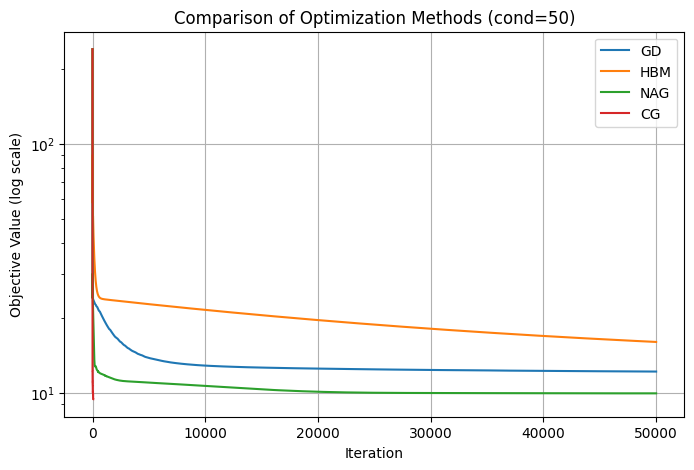

In [90]:
x0 = np.zeros(x_data.shape[1])
f_LSRL, grad_LSRL = generate_f(x_data, y_data, 0.0)

# These are the optimal parameters for heavy ball method
hbm_alpha = 4 / (np.sqrt(lambda_max) - np.sqrt(lambda_min))**2
hbm_beta = (np.sqrt(lambda_max) - np.sqrt(lambda_min)) / (np.sqrt(lambda_max) + np.sqrt(lambda_min))

# Now we run all of the methods
tol = 0.00000001; max_iters = 50000

x_gd = gd(grad_LSRL, f_LSRL, x0, max_iters, tol, None, 0.5, 0.8)
f_gd = np.apply_along_axis(f_LSRL, 1, x_gd)

# Heavy ball method with optimal parameters:
x_hbm_LSRL = gd_hbm(grad_LSRL, f_LSRL, x0, max_iters, tol, 1.0*hbm_alpha, 0.9*hbm_beta)
f_hbm_LSRL = np.apply_along_axis(f_LSRL, 1, x_hbm_LSRL)

# Nesterov with Tseng parameter
x_nag_LSRL = gd_nesterov1(grad_LSRL, f_LSRL, x0, max_iters, tol, 0.5, 0.5)
f_nag_LSRL = np.apply_along_axis(f_LSRL, 1, x_nag_LSRL)

# Conjugate gradient method
x_cg_LSRL = conjugate_gradient(f_LSRL, grad_LSRL, x0, max_iters, tol)
f_cg_LSRL = np.apply_along_axis(f_LSRL, 1, x_cg_LSRL)

plt.figure(figsize=(8, 5))
plt.plot(f_gd, label="GD")
plt.plot(f_hbm_LSRL, label="HBM")
plt.plot(f_nag_LSRL, label="NAG")
plt.plot(f_cg_LSRL, label="CG")
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("Objective Value (log scale)")
plt.title("Comparison of Optimization Methods (cond=50)")
plt.legend()
plt.grid(True)
plt.show()

In [50]:
f_gd

array([   0.        ,  -90.19054998,  -91.2379172 ,  -93.19061336,
        -94.68405791,  -96.3418002 ,  -97.4188211 ,  -98.88328315,
       -100.04969534, -100.83800074, -101.41810384, -101.94750694,
       -102.36123666, -102.90372548, -103.31287756, -104.03277534,
       -104.47143061, -104.87297794, -105.1887375 , -105.53094205,
       -105.75864765, -106.06088732, -106.3077682 , -106.47140583,
       -106.5891657 ])

In [ ]:
x_data.T @ x_data

array([[2.05000000e+02, 1.71000000e+02, 2.02451000e+04, 3.56801000e+04,
        1.35111000e+04, 1.10136000e+04, 5.23891000e+05, 2.60160000e+04,
        6.82600000e+02, 6.67360000e+02, 2.07922000e+03, 2.13440000e+04,
        1.05065000e+06, 5.17000000e+03, 6.30400000e+03],
       [1.71000000e+02, 4.59000000e+02, 1.60736000e+04, 2.86416000e+04,
        1.11433000e+04, 8.85110000e+03, 4.06884000e+05, 2.05820000e+04,
        5.60440000e+02, 5.55980000e+02, 1.55424000e+03, 1.85160000e+04,
        9.09550000e+05, 4.25300000e+03, 5.31900000e+03],
       [2.02451000e+04, 1.60736000e+04, 2.00673435e+06, 3.53689978e+06,
        1.33640551e+06, 1.08943485e+06, 5.22342828e+07, 2.59837570e+06,
        6.75738600e+04, 6.59682020e+04, 2.06555478e+05, 2.12502280e+06,
        1.03547390e+08, 5.06791000e+05, 6.17958800e+05],
       [3.56801000e+04, 2.86416000e+04, 3.53689978e+06, 6.24114587e+06,
        2.35613832e+06, 1.91992879e+06, 9.23330658e+07, 4.59968640e+06,
        1.19219427e+05, 1.16255755e+0